In [142]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

In [143]:
furtos = pd.read_csv("./furtos_scored.csv")

In [144]:
furtos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19443 entries, 0 to 19442
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   cidade      19443 non-null  object 
 1   bairro      19443 non-null  object 
 2   logradouro  19443 non-null  object 
 3   estacao     19443 non-null  int64  
 4   hora        19443 non-null  int64  
 5   mes         19443 non-null  int64  
 6   dia         19443 non-null  int64  
 7   periodo     19443 non-null  int64  
 8   pontos      19443 non-null  float64
dtypes: float64(1), int64(5), object(3)
memory usage: 1.3+ MB


In [145]:
#furtos.drop(columns=["mes", "dia", "hora", "logradouro"], inplace=True)

In [146]:
furtos["pontos"].describe()

count    19443.000000
mean     25396.993365
std       6664.605612
min       9801.000000
25%      20220.500000
50%      25946.000000
75%      28774.000000
max      38867.000000
Name: pontos, dtype: float64

<AxesSubplot:>

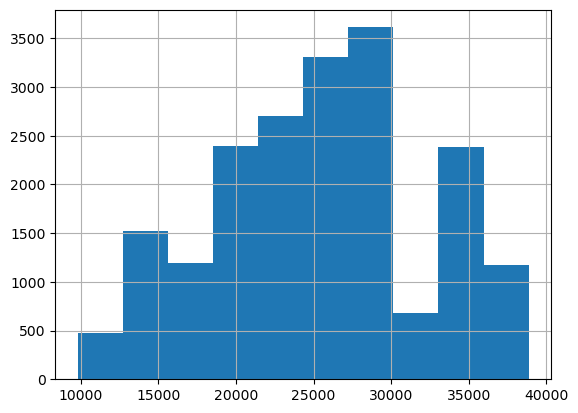

In [147]:
furtos["pontos"].hist()

<AxesSubplot:>

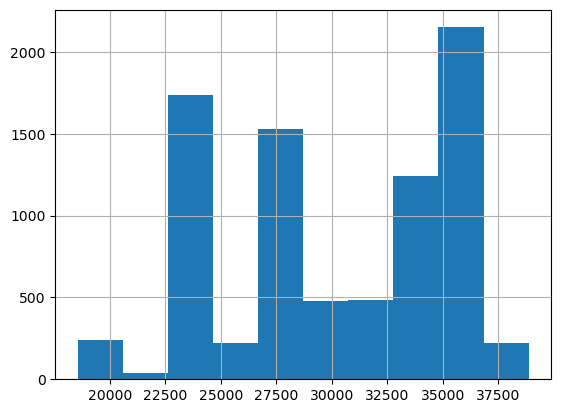

In [148]:
furtos[furtos["cidade"] == "s.paulo"]["pontos"].hist()

<AxesSubplot:>

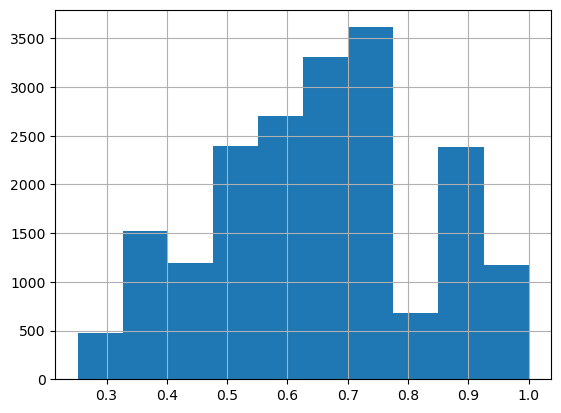

In [149]:
max_points = furtos["pontos"].max()
furtos["pontos"] = (furtos["pontos"] / max_points)
furtos["pontos"].hist()

In [150]:
preprocessing = ColumnTransformer([
    ("categorical", OneHotEncoder(), ["cidade", "bairro", "logradouro"])
], remainder="passthrough")

In [151]:
params = {
    "criterion": ["squared_error", "friedman_mse", "poisson"],
    "max_depth": np.arange(10, 27, 2),
    "min_samples_leaf": np.arange(100, 300, 50)
}
regressor = GridSearchCV(tree.DecisionTreeRegressor(random_state=42), param_grid=params, cv=5, n_jobs=-1)

In [152]:
model = make_pipeline(preprocessing, regressor)

In [153]:
X, y = furtos.iloc[:, 0:8], furtos.iloc[:, 8]

In [154]:
model.fit(X, y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(),
                                                  ['cidade', 'bairro'])])),
                ('gridsearchcv',
                 GridSearchCV(cv=5,
                              estimator=DecisionTreeRegressor(random_state=42),
                              n_jobs=-1,
                              param_grid={'criterion': ['squared_error',
                                                        'friedman_mse',
                                                        'poisson'],
                                          'max_depth': array([10, 12, 14, 16, 18, 20, 22, 24, 26]),
                                          'min_samples_leaf': array([100, 150, 200, 250])}))])

In [155]:
print(model.score(X, y))
y_pred = model.predict(X)

0.9776126426992168


(array([ 477., 2001.,  486., 2222., 1397., 2062., 5385., 1761.,    0.,
        3652.]),
 array([0.28048336, 0.3441647 , 0.40784605, 0.4715274 , 0.53520874,
        0.59889009, 0.66257144, 0.72625278, 0.78993413, 0.85361548,
        0.91729682]),
 <BarContainer object of 10 artists>)

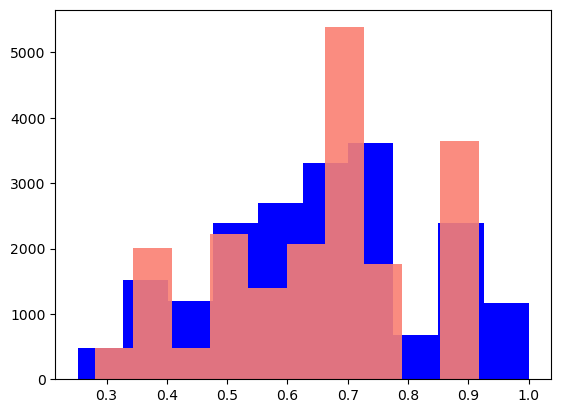

In [156]:
plt.hist(y, color="b")
plt.hist(y_pred, color="salmon", alpha=.9)

In [157]:
results = model["gridsearchcv"].cv_results_
results = pd.DataFrame(results)

In [158]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   mean_fit_time           108 non-null    float64
 1   std_fit_time            108 non-null    float64
 2   mean_score_time         108 non-null    float64
 3   std_score_time          108 non-null    float64
 4   param_criterion         108 non-null    object 
 5   param_max_depth         108 non-null    object 
 6   param_min_samples_leaf  108 non-null    object 
 7   params                  108 non-null    object 
 8   split0_test_score       108 non-null    float64
 9   split1_test_score       108 non-null    float64
 10  split2_test_score       108 non-null    float64
 11  split3_test_score       108 non-null    float64
 12  split4_test_score       108 non-null    float64
 13  mean_test_score         108 non-null    float64
 14  std_test_score          108 non-null    fl

array([<AxesSubplot:title={'center':'mean_fit_time'}, xlabel='param_criterion'>,
       <AxesSubplot:title={'center':'mean_test_score'}, xlabel='param_criterion'>],
      dtype=object)

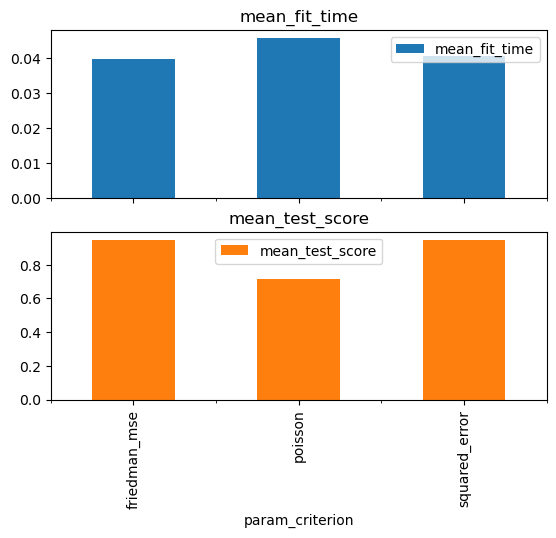

In [159]:
results.groupby("param_criterion")[["mean_fit_time", "mean_test_score"]].mean().plot(kind="bar", subplots=True)

array([<AxesSubplot:xlabel='param_max_depth'>,
       <AxesSubplot:xlabel='param_max_depth'>], dtype=object)

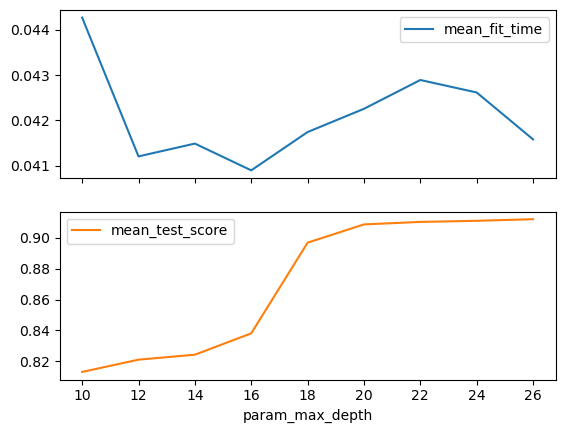

In [160]:
results.groupby("param_max_depth")[["mean_fit_time", "mean_test_score"]].mean().plot(kind="line", subplots=True)

array([<AxesSubplot:xlabel='param_min_samples_leaf'>,
       <AxesSubplot:xlabel='param_min_samples_leaf'>], dtype=object)

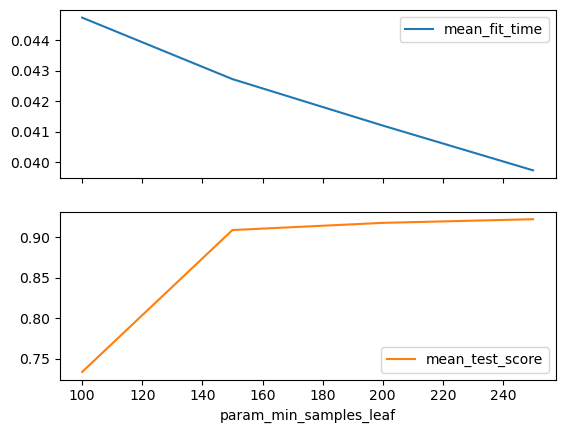

In [161]:
results.groupby("param_min_samples_leaf")[["mean_fit_time", "mean_test_score"]].mean().plot(kind="line", subplots=True)

In [162]:
furtos["pred"] = y_pred

<AxesSubplot:xlabel='periodo'>

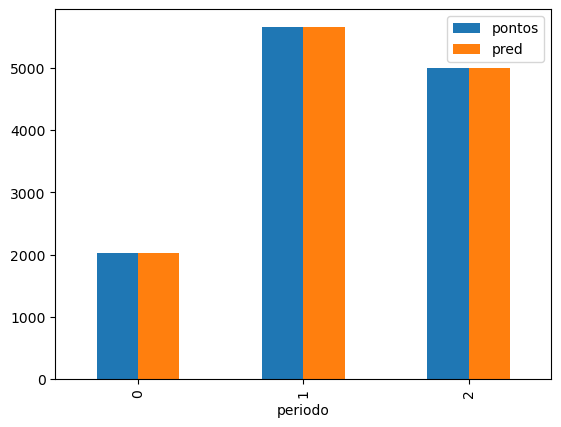

In [163]:
furtos.groupby("periodo")[["pontos", "pred"]].sum().plot(kind="bar")

<AxesSubplot:xlabel='estacao'>

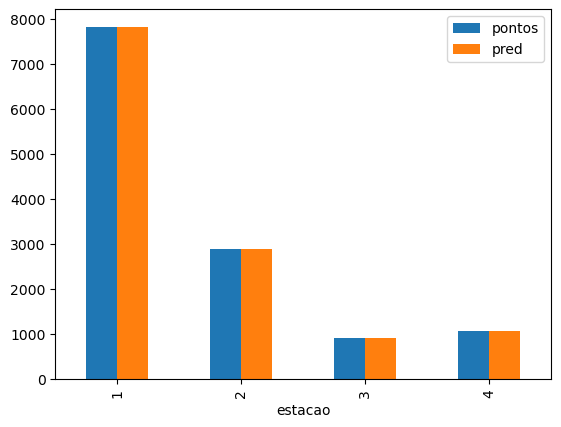

In [164]:
furtos.groupby("estacao")[["pontos", "pred"]].sum().plot(kind="bar")

<AxesSubplot:xlabel='bairro'>

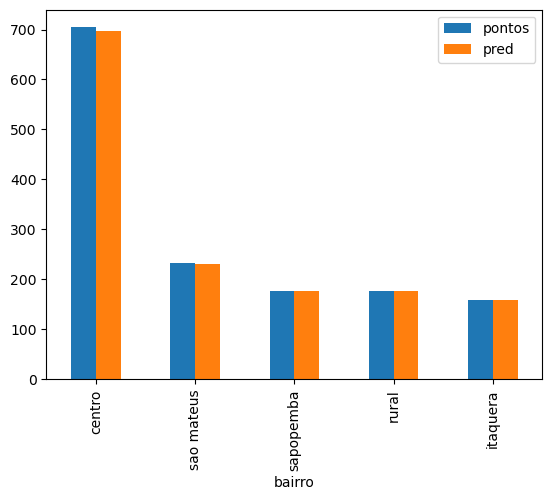

In [165]:
furtos.groupby("bairro")[["pontos", "pred"]].sum().sort_values("pontos", ascending=False).head().plot(kind="bar")

In [168]:
furtos.groupby("logradouro")[["pontos", "pred"]].sum().sort_values("pontos", ascending=False).head().plot(kind="bar")

<AxesSubplot:xlabel='cidade'>

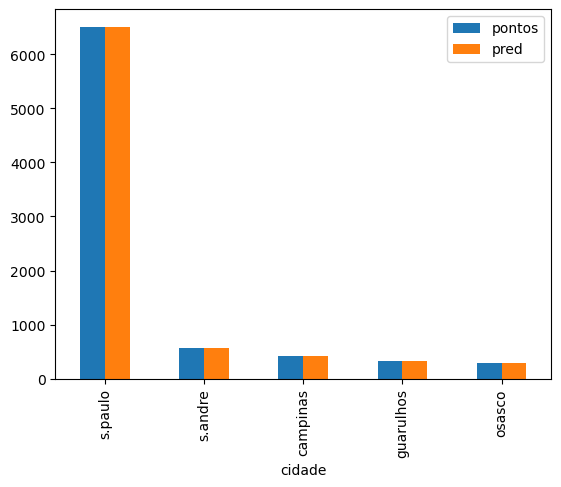

In [167]:
furtos.groupby("cidade")[["pontos", "pred"]].sum().sort_values("pontos", ascending=False).head().plot(kind="bar")